# IUM 25L - Projekt
Advanced model

In [1]:
from sklearn.metrics import mean_absolute_error, median_absolute_error, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pprint

from nocarz.config import PROCESSED_DATA_DIR, MODELS_DIR, INPUT_COLUMNS, NUMERICAL_TARGETS, CATEGORICAL_TARGETS
from nocarz.src.advanced_model import AdvancedModel

### Preparing the data

In [2]:
train_data = pd.read_csv(PROCESSED_DATA_DIR / "train.csv")
test_data = pd.read_csv(PROCESSED_DATA_DIR / "test.csv")

train_data = train_data.dropna(subset=NUMERICAL_TARGETS + CATEGORICAL_TARGETS).reset_index(drop=True)

for col in INPUT_COLUMNS:
    train_data[col] = train_data[col].fillna("")
    test_data[col] = test_data[col].fillna("")

### Training the model

In [3]:
advanced_model = AdvancedModel()
advanced_model.fit(train_data[INPUT_COLUMNS], train_data[NUMERICAL_TARGETS + CATEGORICAL_TARGETS])
advanced_model.save(MODELS_DIR / "advanced_model.pkl")

### Making predictions

In [4]:
results = []

for idx, row in test_data.iterrows():
    predictions = advanced_model.predict(row[INPUT_COLUMNS])

    actual_values = row.to_dict()
    evaluation = AdvancedModel.evaluate_predictions(predictions, actual_values)

    result = {
        'listing_id': idx,
        'host_id': row['host_id'],
        'predictions': predictions,
        'evaluation': evaluation
    }
    results.append(result)

### Calculating the metrics

In [5]:
metrics = {}
pred_numerical = {col: [] for col in NUMERICAL_TARGETS}
true_numerical = {col: [] for col in NUMERICAL_TARGETS}
pred_categorical = {col: [] for col in CATEGORICAL_TARGETS}
true_categorical = {col: [] for col in CATEGORICAL_TARGETS}

for result in results:
    predictions = result['predictions']
    evaluation = result['evaluation']

    for col in NUMERICAL_TARGETS:
        if col in evaluation and evaluation[col]['type'] == 'numerical':
            pred_numerical[col].append(evaluation[col]['predicted'])
            true_numerical[col].append(evaluation[col]['actual'])

    for col in CATEGORICAL_TARGETS:
        if col in evaluation and evaluation[col]['type'] == 'categorical':
            pred_categorical[col].append(evaluation[col]['predicted'])
            true_categorical[col].append(evaluation[col]['actual'])

for col in NUMERICAL_TARGETS:
    if len(pred_numerical[col]) > 0:
        y_true = np.array(true_numerical[col])
        y_pred = np.array(pred_numerical[col])

        metrics[col] = {
            "mean_absolute_error": mean_absolute_error(y_true, y_pred),
            "median_absolute_error": median_absolute_error(y_true, y_pred),
            "count": len(y_true)
        }

for col in CATEGORICAL_TARGETS:
    if len(pred_categorical[col]) > 0:
        y_true = true_categorical[col]
        y_pred = pred_categorical[col]

        metrics[col] = {
            "accuracy": accuracy_score(y_true, y_pred),
            "count": len(y_true)
        }

pprint.pprint(metrics)

{'accommodates': {'count': 552,
                  'mean_absolute_error': 0.8498042328042328,
                  'median_absolute_error': np.float64(0.6699999999999999)},
 'bathrooms': {'count': 405,
               'mean_absolute_error': 0.2344934646286498,
               'median_absolute_error': np.float64(0.09499999999999997)},
 'bathrooms_text': {'accuracy': 0.6557971014492754, 'count': 552},
 'bedrooms': {'count': 499,
              'mean_absolute_error': 0.40312606164710374,
              'median_absolute_error': np.float64(0.22999999999999998)},
 'beds': {'count': 404,
          'mean_absolute_error': 0.6265008840169731,
          'median_absolute_error': np.float64(0.43999999999999995)},
 'price': {'count': 405,
           'mean_absolute_error': 60.36933454830491,
           'median_absolute_error': np.float64(30.590000000000003)},
 'property_type': {'accuracy': 0.7590579710144928, 'count': 552},
 'room_type': {'accuracy': 0.907608695652174, 'count': 552}}


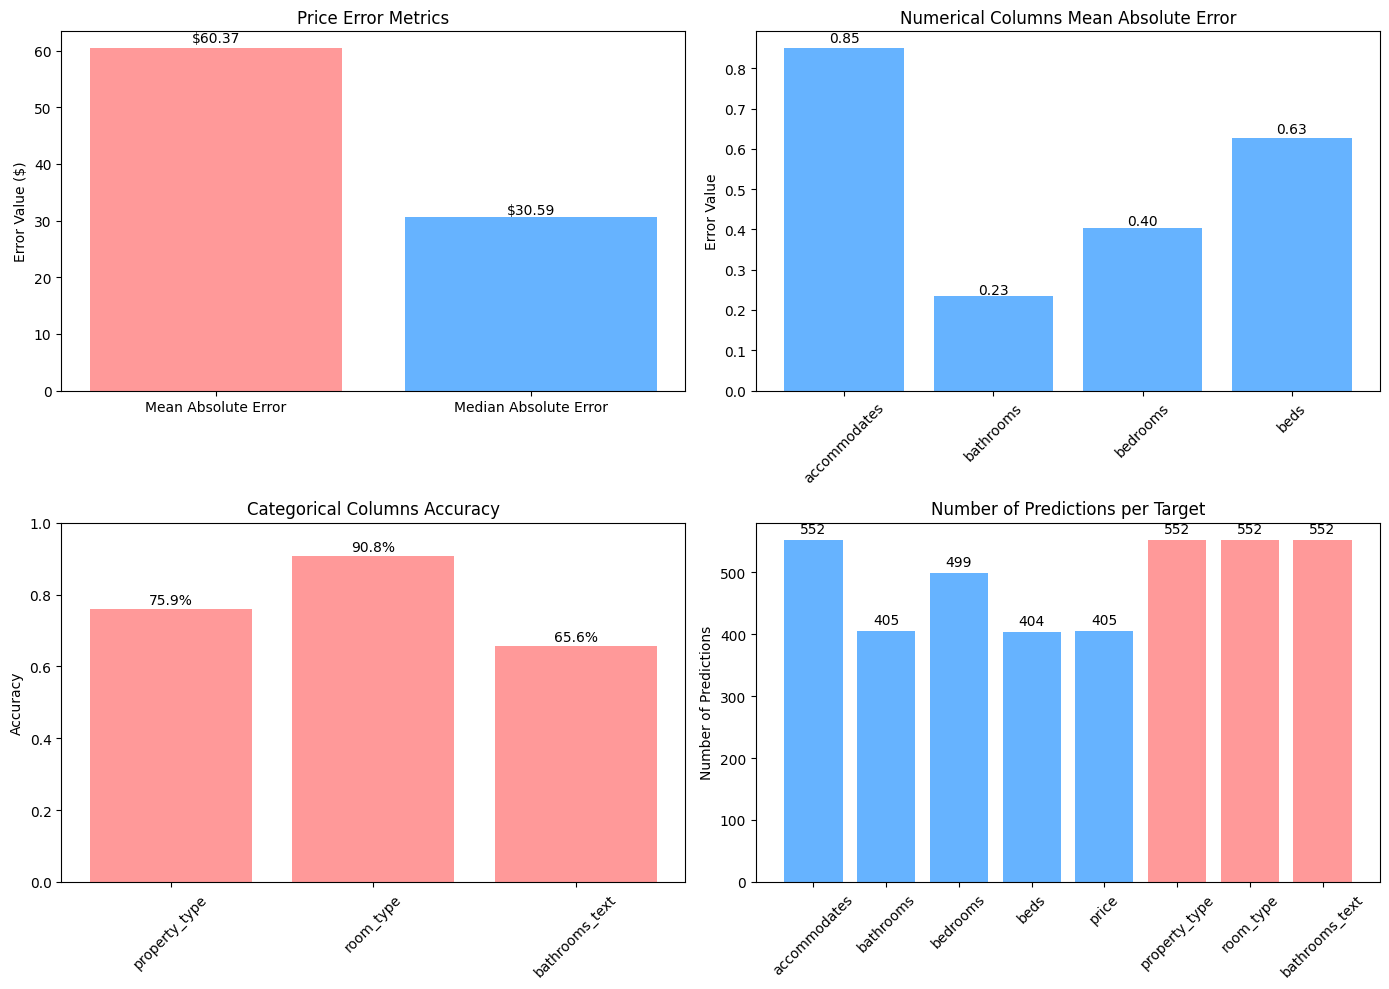

In [6]:
RED = '#ff9999'
BLUE = '#66b3ff'
plt.figure(figsize=(14, 10))

# 1. Create a subplot for price MAE
plt.subplot(2, 2, 1)
if 'price' in metrics:
    price_mae = metrics['price']['mean_absolute_error']
    price_med = metrics['price']['median_absolute_error']

    plt.bar(["Mean Absolute Error", "Median Absolute Error"], [price_mae, price_med],
            color=[RED, BLUE])
    plt.ylabel("Error Value ($)")
    plt.title("Price Error Metrics")
    plt.text(0, price_mae + price_mae*0.02, f"${price_mae:.2f}", ha="center")
    plt.text(1, price_med + price_med*0.02, f"${price_med:.2f}", ha="center")

# 2. Create a subplot for numerical columns MAE
plt.subplot(2, 2, 2)
non_price_cols = [col for col in NUMERICAL_TARGETS if col != "price" and col in metrics]
non_price_maes = [metrics[col]['mean_absolute_error'] for col in non_price_cols]

if non_price_maes:
    plt.bar(non_price_cols, non_price_maes, color=BLUE)
    plt.title("Numerical Columns Mean Absolute Error")
    plt.ylabel("Error Value")
    plt.xticks(rotation=45)
    for i, val in enumerate(non_price_maes):
        plt.text(i, val + val*0.02, f"{val:.2f}", ha="center")

# 3. Create a subplot for categorical accuracy
plt.subplot(2, 2, 3)
categorical_cols = [col for col in CATEGORICAL_TARGETS if col in metrics]
accuracies = [metrics[col]['accuracy'] for col in categorical_cols]

if accuracies:
    plt.bar(categorical_cols, accuracies, color=RED)
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.title("Categorical Columns Accuracy")
    plt.xticks(rotation=45)
    for i, val in enumerate(accuracies):
        plt.text(i, val + 0.015, f"{val:.1%}", ha="center")

# 4. Number of predictions
plt.subplot(2, 2, 4)
num_predictions = []
bar_colors = []
labels = []

for col in NUMERICAL_TARGETS:
    num_predictions.append(metrics[col]['count'])
    bar_colors.append(BLUE)
    labels.append(col)
for col in CATEGORICAL_TARGETS:
    num_predictions.append(metrics[col]['count'])
    bar_colors.append(RED)
    labels.append(col)

plt.bar(labels, num_predictions, color=bar_colors)
plt.ylabel("Number of Predictions")
plt.title("Number of Predictions per Target")
plt.xticks(rotation=45)
for i, val in enumerate(num_predictions):
    plt.text(i, val + 0.02 * max(num_predictions), str(val), ha="center")

plt.tight_layout()
plt.show()